In [69]:
!pip install -q tensorflow_text

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [72]:
use_builtins = True

# The data

## Download and prepare the dataset

In [73]:
# /content/drive/MyDrive/MasterThesis/paraphrasing/Parapgrasing-Masking.tsv

# Download the file
import pathlib

# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
# path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/Parapgrasing - Masking2.tsv')
path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/ParapgrasingMask/ParapgrasingMasking.tsv')
# path_to_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/ParapgrasingMask/ParapgrasingMasking.tsv')


In [74]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  # inp = [inp for targ, inp in pairs]
  # targ = [targ for targ, inp in pairs]

  targ = [inp for targ, inp in pairs]
  inp = [targ for targ, inp in pairs]
  return targ, inp

In [75]:
targ, inp = load_data(path_to_file)
print(inp[3])

يا جابر يا بنجرجي يا مرتزق يا حثالة الحمدين يا خربوط يا ساذج يا مليق يا إمعه يا مسيلمة الكذاب يا هامشهري آغا ملالي إيراني يا زهرا مار يا يا يا يا تتشمت بمصر وأبناء مصر !! أتعلم بأنك لست برجل ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت حثالة ومن أتباع الحثالة يا خسيس


In [76]:
print(targ[3])

يا جابر يا بنجرجي يا *****يا *****الحمدين يا *****يا ****يا ****يا ****يا ************ يا هامشهري آغا ملالي إيراني يا زهرا مار يا يا يا يا تتشمت بمصر وأبناء مصر !! أتعلم بأنك ******* ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت *****ومن أتباع *******يا ****


In [131]:
from sklearn.model_selection import train_test_split

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(inp, targ, test_size=0.2)


# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

## Create a tf.data dataset

In [78]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [79]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE)

In [80]:
for example_input_batch, example_target_batch in dataset_val.take(1):
  for i in range(5):
      print(example_input_batch.numpy()[i].decode('utf-8'))
      # print()
      print(example_target_batch.numpy()[i].decode('utf-8'))
      print()
  break

"إقلع غماك يا تور وارفض تلف إكسر تروس الساقية و اشتم وتف قال : بس خطوة كمان .. وخطوة كمان يا اوصل نهاية السكة يا البير تجف…
"إقلع غماك يا ***وارفض تلف إكسر تروس الساقية و اشتم و** قال : بس خطوة كمان .. وخطوة كمان يا اوصل نهاية السكة يا البير تجف…

يا شافعى يا هايف انا شايفك 😂😂😂😂
يا شافعى يا ****انا شايفك 😂😂😂😂

يا وضضييع يا نقصصص ست اهدافك تعرف وين تحططهممم يا صيييااااااحححح سسمعني صييياحكككك يا نقصصصص
يا ******يا *****ست اهدافك تعرف وين تحططهممم يا صيييااااااحححح سسمعني صييياحكككك يا *****

ههههههههه..آه منك يا محسن يا متحوش ..المفروض ذا الكلام يتوجه لحماده هل عاد فيه دم ولا مروءة .لا تحرك بداعي الوطنيه ولا بداعي الثأر لوالده .عايش خمسه نجوم وفوق هذا يطلب رفع العقوبات هههه.يا ليت الشعب كله يتعاقب مثلك بس
ههههههههه..آه منك يا محسن يا *****..المفروض ذا الكلام يتوجه لحماده هل عاد فيه دم ولا مروءة .لا تحرك بداعي الوطنيه ولا بداعي الثأر لوالده .عايش خمسه نجوم وفوق هذا يطلب رفع العقوبات هههه.يا ليت الشعب كله يتعاقب مثلك بس

الحين تكتب لي لا تصير عنصري وتكتب هنا خدم حمار انت حمار مثل فريقك تع

## Text preprocessing

In [81]:
example_text = tf.constant('#إغلاق_حسابات_البدون_في_البنوك الحل على إ رصاصة سلاإأم يا فيك يا فيه نقطه اخر السطر .')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'#\xd8\xa5\xd8\xba\xd9\x84\xd8\xa7\xd9\x82_\xd8\xad\xd8\xb3\xd8\xa7\xd8\xa8\xd8\xa7\xd8\xaa_\xd8\xa7\xd9\x84\xd8\xa8\xd8\xaf\xd9\x88\xd9\x86_\xd9\x81\xd9\x8a_\xd8\xa7\xd9\x84\xd8\xa8\xd9\x86\xd9\x88\xd9\x83 \xd8\xa7\xd9\x84\xd8\xad\xd9\x84 \xd8\xb9\xd9\x84\xd9\x89 \xd8\xa5 \xd8\xb1\xd8\xb5\xd8\xa7\xd8\xb5\xd8\xa9 \xd8\xb3\xd9\x84\xd8\xa7\xd8\xa5\xd8\xa3\xd9\x85 \xd9\x8a\xd8\xa7 \xd9\x81\xd9\x8a\xd9\x83 \xd9\x8a\xd8\xa7 \xd9\x81\xd9\x8a\xd9\x87 \xd9\x86\xd9\x82\xd8\xb7\xd9\x87 \xd8\xa7\xd8\xae\xd8\xb1 \xd8\xa7\xd9\x84\xd8\xb3\xd8\xb7\xd8\xb1 .'
b'#\xd8\xa7\xd9\x95\xd8\xba\xd9\x84\xd8\xa7\xd9\x82_\xd8\xad\xd8\xb3\xd8\xa7\xd8\xa8\xd8\xa7\xd8\xaa_\xd8\xa7\xd9\x84\xd8\xa8\xd8\xaf\xd9\x88\xd9\x86_\xd9\x81\xd9\x8a_\xd8\xa7\xd9\x84\xd8\xa8\xd9\x86\xd9\x88\xd9\x83 \xd8\xa7\xd9\x84\xd8\xad\xd9\x84 \xd8\xb9\xd9\x84\xd9\x89 \xd8\xa7\xd9\x95 \xd8\xb1\xd8\xb5\xd8\xa7\xd8\xb5\xd8\xa9 \xd8\xb3\xd9\x84\xd8\xa7\xd8\xa7\xd9\x95\xd8\xa7\xd9\x94\xd9\x85 \xd9\x8a\xd8\xa7 \xd9\x81\xd9\x8a\xd9\x83 \xd9\x8a\x

In [82]:
import re
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"

def tf_lower_and_split_punct(text):
  text = tf.strings.regex_replace(text, '[إأآا]', 'ا')
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  # text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.

  text = tf.strings.regex_replace(text, '[.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿_#]', r' \0 ')
  # Strip whitespace.


  # text = tf.strings.strip(text)
  # text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  # text = tf.strings.regex_replace(text, r'(.)\1+', r'\1\1')
  text = tf.strings.regex_replace(text,text_cleaning_re, '')
  text = tf.strings.regex_replace(text, 'ى', 'ي')
  text = tf.strings.regex_replace(text, "ة", "ه")

  text = tf.strings.regex_replace(text, '[إأآا]', 'ا')


  # text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  # text = re.sub("[إأآا]", "ا", str(text))
  # text = re.sub("ى", "ي", str(text))
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [15]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

#إغلاق_حسابات_البدون_في_البنوك الحل على إ رصاصة سلاإأم يا فيك يا فيه نقطه اخر السطر .
[START]   اغلاق  حسابات  البدون  في  البنوك الحل علي ا رصاصه سلااام يا فيك يا فيه نقطه اخر السطر  [END]


## Text Vectorization

In [85]:
max_vocab_size = 5000
####TextVectorization Before paraphrasing

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    # output_mode="int",

    max_tokens=max_vocab_size
    
    )
input_text_processor.adapt(input_tensor_train)
input_text_processor.adapt(input_tensor_val)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 'يا',
 '[START]',
 '[END]',
 'من',
 'و',
 'في',
 'الله',
 'انت',
 'ما',
 'علي',
 'لا',
 'اللي',
 'ابن',
 'ولا',
 'الي',
 'بس',
 'ان',
 'ابو']

In [86]:
#TextVectorization after paraphrasing(masking)

output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(target_tensor_train)
output_text_processor.adapt(target_tensor_val)
output_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 'يا',
 '[START]',
 '[END]',
 'من',
 'و',
 'في',
 '****يا',
 '*****يا',
 'الله',
 '****',
 'ما',
 '***',
 'انت',
 'علي',
 '*****',
 'ال****',
 'لا',
 'اللي']

In [88]:
#Now these layers can convert a batch of strings into a batch of token IDs:

example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   3, 3565, 1882,    2, 2504, 1217, 2529, 3396, 2612, 3200],
       [   3,    2, 2104,    2, 1278,   21, 2100,  811,    4,    0],
       [   3,    2, 1064,    2, 1308,  548, 2936,  202,   79, 2638]])>

In [89]:
#The get_vocabulary method can be used to convert token IDs back to text:

input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] "اقلع غماك يا تور وارفض تلف اكسر تروس الساقيه و اشتم وتف قال : بس خطوه كمان وخطوه كمان يا اوصل نهايه السكه يا البير تجف [END]                                '

Text(0.5, 1.0, 'Mask')

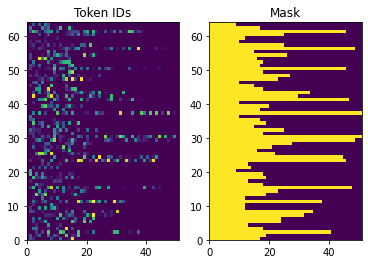

In [21]:
#The returned token IDs are zero-padded. This can easily be turned into a mask:

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

#The encoder/decoder model

In [90]:
embedding_dim = 256
units = 1024

##The encoder

In [91]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [92]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [93]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 60)
Encoder output, shape (batch, s, units): (64, 60, 1024)
Encoder state, shape (batch, units): (64, 1024)


##The attention head

In [94]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

##Test the Attention layer

In [95]:
attention_layer = BahdanauAttention(units)

In [96]:
(example_tokens != 0).shape

TensorShape([64, 60])

In [97]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 60)


Text(0.5, 1.0, 'Mask')

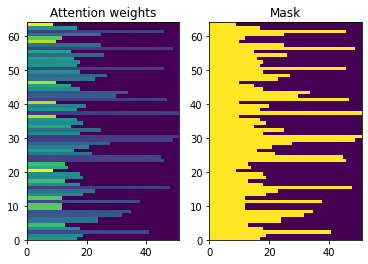

In [30]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [98]:
attention_weights.shape

TensorShape([64, 2, 60])

In [99]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

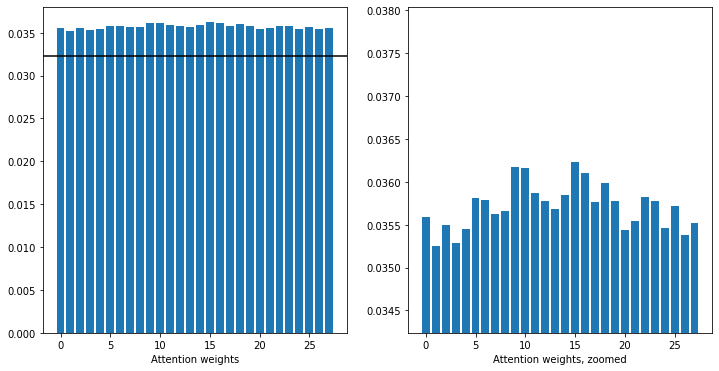

In [100]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

##The decoder

In [101]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [102]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [103]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state
  

In [104]:
Decoder.call = call

In [105]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [106]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [107]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 3262)
state shape: (batch_size, dec_units) (64, 1024)


In [108]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [109]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['متعب'],
       ['و*****'],
       ['*****المشكله'],
       ['لجبل'],
       ['الموت']], dtype='<U47')

In [110]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [111]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['الشيوخ'],
       ['الحاج'],
       ['بتعارض'],
       ['سجل'],
       ['لناديه']], dtype='<U47')

#Training

## Define the loss function

In [112]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

## Implement the training step

In [113]:
#Implement the training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [114]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [115]:
TrainTranslator._preprocess = _preprocess

In [116]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [117]:
TrainTranslator._train_step = _train_step

In [118]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [119]:
TrainTranslator._loop_step = _loop_step

## Test the training step

In [120]:
#Test the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=["accuracy"]
)

In [121]:
np.log(output_text_processor.vocabulary_size())

8.09009578318096

In [122]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7416162>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.722608>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.685562>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.571116>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.089094>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=13.164285>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.887095>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.845187>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.420075>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.3474884>}

CPU times: user 17.8 s, sys: 345 ms, total: 18.1 s
Wall time: 1min 3s


In [123]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [124]:
TrainTranslator._tf_train_step = _tf_train_step

In [125]:
translator.use_tf_function = True

In [126]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.0764527>}

In [127]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.0450134>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.007957>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9940205>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9848714>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9595413>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.92156>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.8803005>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.840612>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.804723>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.773209>}

CPU times: user 13 s, sys: 1.3 s, total: 14.3 s
Wall time: 9.38 s


....................................................................................................


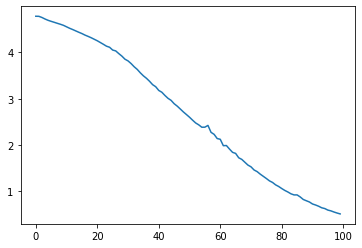

In [61]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [128]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=["accuracy"]
)

## Train the model

In [129]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []
  
  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [64]:
# # Splitting the dataset for training and testing.
# def is_val(x, _):
#     return x % 4 == 0


# def is_train(x, y):
#     return not is_val(x, y)


# recover = lambda x, y: y

# # Split the dataset for training.
# val_dataset = dataset.enumerate() \
#     .filter(is_val) \
#     .map(recover)

# # Split the dataset for testing/validation.
# train_dataset = dataset.enumerate() \
#     .filter(is_train) \
#     .map(recover)

In [130]:
from keras.callbacks import EarlyStopping


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
    #                                  min_lr = 0.01,
    #                                  monitor = 'val_loss',
    #                                  verbose = 1)
    # batch_loss = BatchLogs('batch_loss')
]

In [ ]:
# train_translator.fit(train_dataset,val_dataset, epochs=3,validation_steps=50,callbacks=my_callbacks)
train_translator.fit(dataset,callbacks=my_callbacks,epochs=3)

Epoch 1/3
20/20 [==============================] - 18s 895ms/step - batch_loss: 3.5689
Epoch 2/3
20/20 [==============================] - 18s 893ms/step - batch_loss: 3.5365
Epoch 3/3
20/20 [==============================] - 18s 897ms/step - batch_loss: 3.4759


Text(0, 0.5, 'CE/token')

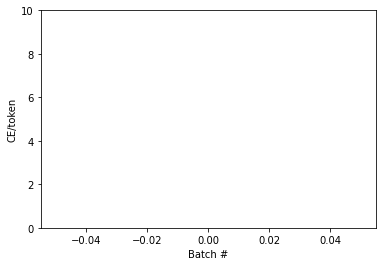

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

#Translate

In [70]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder  
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

In [71]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

##Convert token IDs to text

In [72]:
#Convert token IDs to text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [73]:
Translator.tokens_to_text = tokens_to_text

In [74]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'\xd9\x82\xd8\xa8\xd9\x84 \xd8\xa7\xd9\x84\xd9\x83\xd9\x88\xd8\xb1\xd9\x87',
       b'\xd8\xb6\xd8\xaf \xd8\xad\xd9\x85\xd8\xaf',
       b'\xd8\xa8\xd8\xb1\xd8\xa7\xd8\xaf \xd9\x86\xd8\xad\xd8\xa7\xd8\xb1\xd8\xa8',
       b'\xd8\xa7\xd9\x86\xd9\x85\xd8\xa7 \xd9\x87\xd8\xa7\xd8\xb0\xd9\x8a',
       b'\xd9\x85\xd9\x86\xd9\x8a \xd9\x87\xd9\x85\xd9\x87'], dtype=object)

## Sample from the decoder's predictions

In [75]:
#Sample from the decoder's predictions

def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [76]:
Translator.sample = sample

In [77]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[3046],
       [1385],
       [3022],
       [4948],
       [2592]])>

In [78]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2112],
       [ 155],
       [  25],
       [2734],
       [1704]])>

## Implement the translation loop

In [79]:
#Implement the translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [80]:
Translator.translate = translate_unrolled

In [81]:
%%time
input_text = tf.constant([
    'بكري يا معرص يا عار الصعيد ملعون ضهر ابوك يا عرص', # "It's really cold here."
    'تبا لكم ولأشكالكم', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

صفري اقول يا ****يا *****
من **** زاده يا روح يا بالك

CPU times: user 198 ms, sys: 4.03 ms, total: 202 ms
Wall time: 218 ms


In [82]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)
print(result['text'][0].numpy().decode())

ضعيف وفزنا بلدك يا **** يا كله كل يا امك يا ال**** الشيخ زمالك
CPU times: user 18 s, sys: 499 ms, total: 18.5 s
Wall time: 18.3 s


In [84]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

***ولا لعنك يسلموا يا الله
رغم رحم لم قوم يا **** ***يا و الضيوف ليكي رحم 😂😂😂 اليغري

CPU times: user 141 ms, sys: 20.7 ms, total: 162 ms
Wall time: 134 ms


## Visualize the process

In [85]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         1.0000001  1.         1.         1.0000001  1.
 0.99999994 1.         1.         1.0000001  0.99999994 0.99999994
 1.         0.99999994 1.         1.         0.99999994 0.99999994
 1.0000001  0.9999999  1.         0.9999999  1.         0.99999994
 1.         0.99999994 1.         1.0000001  1.         1.
 1.         1.         0.99999994 1.0000001  1.0000001  0.9999999
 1.0000001  1.         0.99999994 0.99999994 1.         0.99999994
 0.99999994 1.         1.         0.99999994 1.0000001  1.
 1.         1.        ]


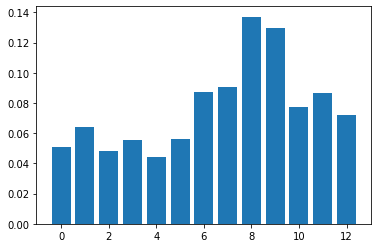

In [86]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

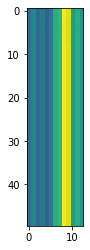

In [87]:
plt.imshow(np.array(a), vmin=0.0)

In [88]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

## Labeled attention plots

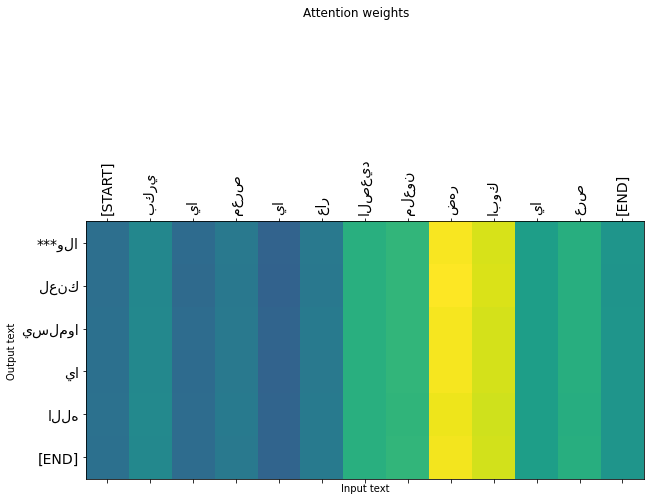

In [89]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [90]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'يا راس هرم الفساد ف مصر معلش انت مش عارف تشغلهم',
    # Are they still home?
    'برجل ولا يوصف بك كرجل ولا من اتباع الرجال انت أنت حثالة ومن أتباع الحثالة يا خسيس',
    # Try to find out.'
    'كسمك يا بكاري يا جساما يا ابن المنايك',
    'فين يا ابن القحبه يا معرص السودان مش هيعملوا اَي شي من مخططكم هاهاهاهاها و لسه يا خونه',
    'يا حقير يا واطي يا داعر يا روكي لوليتش قاعد يلعب مصارعة 5 كورة يضرب فيها وما ياخذ عليها كرت ولا حتى فاول !!!!!!!!!!!!!!!!!!!!!'
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

يا نفتخر ***** *** لا في تربيه يا هو *****
روح *** تخسي بس يا يا بنحبك انت وهم
الله ويكند ***** حال الله تحريات
****يا يا يا ****يا يا ***** و *****يا خدمي الرز يا يا الزمالك
عدا نص 😎😎💗 مئات ال****** بس

CPU times: user 169 ms, sys: 12.5 ms, total: 182 ms
Wall time: 138 ms


In [91]:
result['text'][1].numpy().decode()

'روح *** تخسي بس يا يا بنحبك انت وهم'

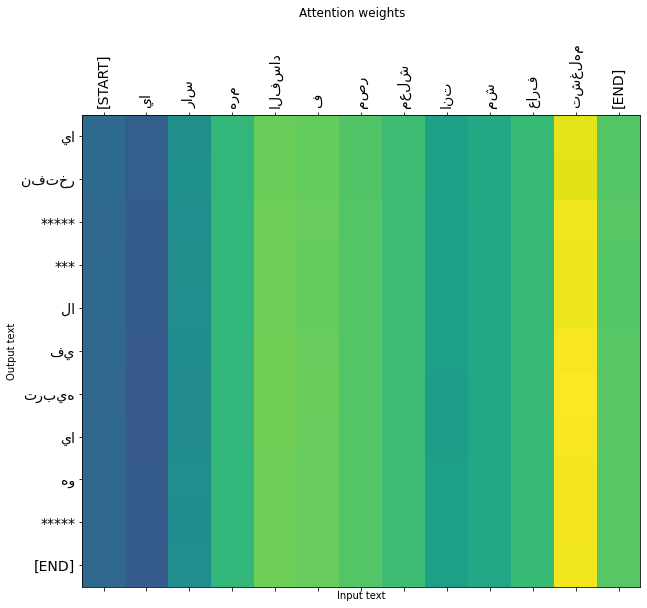

In [92]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

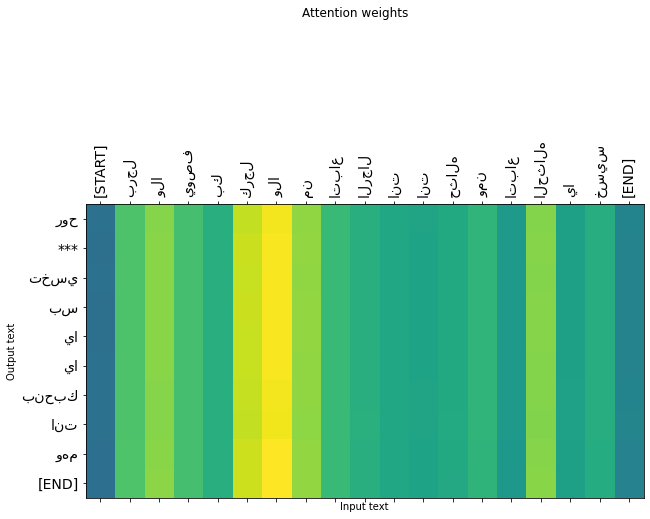

In [93]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

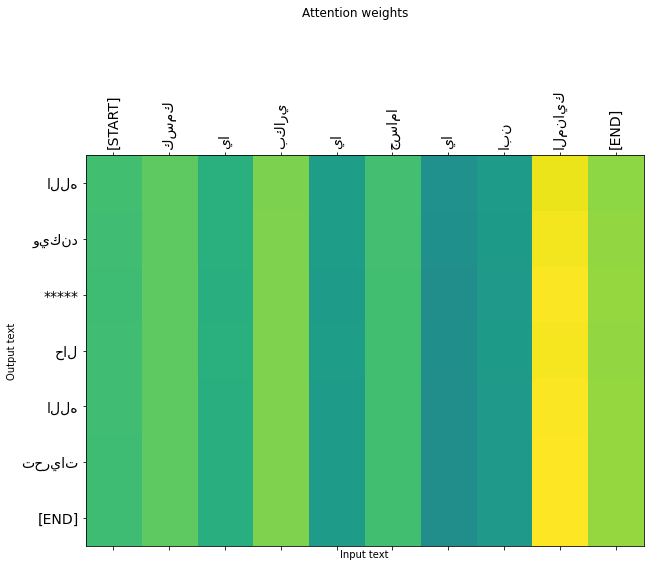

In [94]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [95]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 كل **يا *****يا ****يا ****يا تافه يا **** ************* عليك


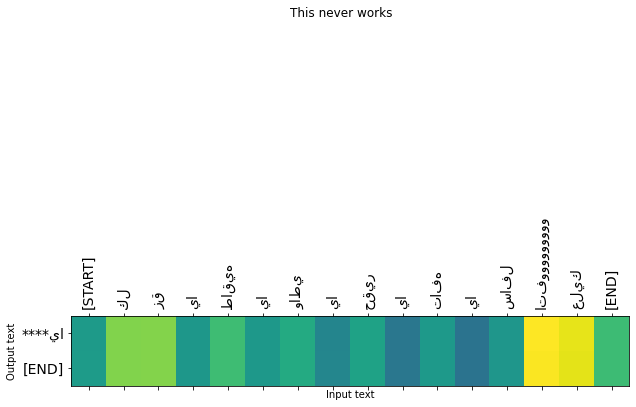

In [96]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

# Evalution Training (BLUE SCORE)

In [97]:
# from nltk.translate.bleu_score import corpus_bleu
# predictedTraining = []
# # for tr in range(len(inp)):
# for i in range(1593):
#   input_text = tf.constant(inp[:1592])
#   # test_input_text = tf.constant(inp_test[:5])
#   # result = translator.tf_translate(input_text)
#   result = translator.tf_translate(input_text[:1592])
#   result= result['text'][i].numpy().decode()
#   predicted_train_list = list(result.split("\n"))
#   predictedTraining.append(predicted_train_list)

# bleu_dic = {}
# bleu_dic['1-grams'] = corpus_bleu(targ, predictedTraining, weights=(1.0, 0, 0, 0))
# bleu_dic['1-2-grams'] = corpus_bleu(targ, predictedTraining, weights=(0.5, 0.5, 0, 0))
# bleu_dic['1-3-grams'] = corpus_bleu(targ, predictedTraining, weights=(0.3, 0.3, 0.3, 0))
# bleu_dic['1-4-grams'] = corpus_bleu(targ, predictedTraining, weights=(0.25, 0.25, 0.25, 0.25))

# res = "\n\n\n".join("Input: {} \nActual: {} \nPredicted: {}".format(x, y,z) for x, y, z in zip(inp, targ, predictedTraining))
# print(" \n-------------\n BLUE SCORE : \n-------------\n ",bleu_dic, "\n\n\n-------------\n")

# print(res , "\n\n\n-------------\n")


# Evaluation (Blue score)



*   Load test data
*   Translate each setance 
*   Append translates setances to array (new columne)
*   For loop 
*   Calculate corpus_bleu for pred and actual 





In [98]:
test_file = pathlib.Path('/content/drive/MyDrive/MasterThesis/paraphrasing/paraphrasingTest.tsv')

targ_test, inp_test = load_data(test_file)

test_dataset = tf.data.Dataset.from_tensor_slices((inp_test, targ_test)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [99]:
for example_input_batch, example_target_batch in test_dataset.take(1):
  for i in range(5):
      print(example_input_batch.numpy()[i].decode('utf-8'))
      # print()
      print(example_target_batch.numpy()[i].decode('utf-8'))
      print()
  break

#اقاله_زوران_مهر_الدوري الان قدامك ٥ الى ٦ ايام على المباراة الجايه قدام التعاون.. ياخي اكرش الحمار وجب مكانه يا جيسوس يا دياز ياخي كلهم فاضين لك وكلهم احسن من التيس الي عندك وكل واحد يقول لك تعال تعاقد معي... اما نظام العب بتاريخ الهلال وبنفسيات الجماهير غلط !
#اقاله_زوران_مهر_الدوري الان قدامك ٥ الى ٦ ايام على المباراة الجايه قدام التعاون.. ياخي **** ****** وجب مكانه يا جيسوس يا دياز ياخي كلهم فاضين لك وكلهم احسن من التيس الي عندك وكل واحد يقول لك تعال تعاقد معي... اما نظام العب بتاريخ الهلال وبنفسيات الجماهير غلط !

5 إنذارات في شوط واحد !!! ، ده لو sale مش هاتعمل كده يا نرويجي يا أبن البوبي أنت 😠😠😠😠 #الزمالك_بيراميدز
5 إنذارات في شوط واحد !!! ، ده لو sale مش هاتعمل كده يا نرويجي يا أبن البوبي أنت 😠😠😠😠 #الزمالك_بيراميدز

يا ناموسة يا حيوانه خلااصصص سحبتي دمي كله!!!
يا ****** يا ****** خلااصصص سحبتي دمي كله!!!

معلش يا محمود يا وطنى 😃 احنا رشين الحكام. يارتك كنن بتكلم ساعت مهدى عبيد و لا كنت اخرس ساعتها
معلش يا محمود يا وطنى 😃 احنا **** الحكام. يارتك كنن بتكلم ساعت مهدى عبيد و لا كنت

In [100]:
print(inp_test[2:3])

['باقي البيان وينو ما شفنه يا برهان ورينا يا برهان ورينا شو بيحصل في شلة الكيزان سلم بشير العار للحاكم السجان وباقي الكل…']


In [ ]:
test_input_text = tf.constant(inp_test[:402])

test_result = translator.tf_translate(test_input_text)

for tr in test_result['text']:
  print(tr.numpy().decode())
  # list(tr.split("\n"))

print()

بدي احطهم بفنكشن واشوف شو النتائج

In [108]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

def bleu_score():

  predicted = []
  for tr in range(len(inp_test)):
  # for i in range(5):
    test_input_text = tf.constant(inp_test)
    # test_input_text = tf.constant(inp_test[:5])
    test_result = translator.tf_translate(test_input_text)
    # test_result = translator.tf_translate(test_input_text[:5])
    test_result= test_result['text'][tr].numpy().decode()
    predicted_list = list(test_result.split("\n"))
    predicted.append(predicted_list)
    score = sentence_bleu(targ_test[tr], predicted[tr], weights=(1, 0, 0, 0))
    print("blue score : ",score)

  bleu_dic = {}
  # bleu_dic['1-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(1.0, 0, 0, 0))
  # bleu_dic['1-2-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.5, 0.5, 0, 0))
  # bleu_dic['1-3-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.3, 0.3, 0.3, 0))
  # bleu_dic['1-4-grams'] = corpus_bleu(targ_test[:5], predicted, weights=(0.25, 0.25, 0.25, 0.25))

  bleu_dic['1-grams'] = corpus_bleu(targ_test, predicted, weights=(1.0, 0, 0, 0))
  bleu_dic['1-2-grams'] = corpus_bleu(targ_test, predicted, weights=(0.5, 0.5, 0, 0))
  bleu_dic['1-3-grams'] = corpus_bleu(targ_test, predicted, weights=(0.3, 0.3, 0.3, 0))
  bleu_dic['1-4-grams'] = corpus_bleu(targ_test, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  res = "\n\n\n".join("Input: {} \nActual: {} \nPredicted: {}".format(x, y,z) for x, y, z in zip(inp_test, targ_test, predicted))
  print(" \n-------------\n BLUE SCORE : \n-------------\n ",bleu_dic, "\n\n\n-------------\n")

  print(res , "\n\n\n-------------\n")

  return bleu_dic


bleu_test = bleu_score()
bleu_test

blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue score :  0
blue sco

{'1-2-grams': 0, '1-3-grams': 0, '1-4-grams': 0, '1-grams': 0}

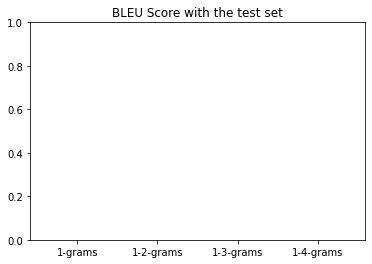

In [104]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

In [105]:
# plt.bar(x = bleu_train.keys(), height = bleu_train.values())
# plt.title("BLEU Score with the training set")
# plt.ylim((0,1))
# plt.show()